# Example use of the Sonic module Nodosus.jl

* https://julialang.org
* https://juliadb.org
* https://juliastats.org

In [77]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [78]:
import Dates, JuliaDB, Random, StatsPlots

In [79]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

In [27]:
include("../src/Linckii.jl")
include("../src/LinckiiSecrets.jl")
include("../src/Nodosus.jl")

Main.Nodosus

Get access token,

In [28]:
@time access = Linckii.get_access(LinckiiSecrets.keab)

  0.003903 seconds (409 allocations: 27.781 KiB)


(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

Load site,

In [29]:
@time nodes, devices, sensors = Linckii.loadsite(access, :nodes, :devices, :sensors)

  0.086826 seconds (75.83 k allocations: 3.920 MiB)


(nodes = Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String, devices = Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13, sensors = Table with 175 rows, 5 columns:
Columns:
#  colname             type
───────────────────

Select data,

In [34]:
device_ids = (4, )

(4,)

In [35]:
sensor_names = (
    :meter_effect,
    :meter_primreturntemp,
    :meter_primsupplytemp,
    :meter_volumeflow,
)

(:meter_effect, :meter_primreturntemp, :meter_primsupplytemp, :meter_volumeflow)

In [40]:
signals = JuliaDB.reindex(
    JuliaDB.join(
        Linckii.flatten_nodes(JuliaDB.filter(r -> r.device_id in device_ids, nodes)),
        JuliaDB.filter(r -> r.sensor_name in sensor_names, sensors);
        lkey = :sensor_id,
        rkey = :sensor_id,
    ),
    (:node_id, :sensor_id),
)

Table with 361 rows, 12 columns:
Columns:
#   colname             type
──────────────────────────────
1   node_id             Int64
2   sensor_id           Int64
3   node_public         Bool
4   node_name           String
5   device_id           Int64
6   node_owner          Bool
7   node_enabled        Bool
8   node_description    String
9   sensor_unit         Any
10  sensor_name         Symbol
11  protocol_id         Int64
12  sensor_description  String

Load data,

In [41]:
p, q = Dates.Minute(10), Dates.Minute(120)

(10 minutes, 120 minutes)

In [44]:
rs = JuliaDB.rows(signals)
if false
    rs = [rs[Random.rand(1 : end)]]
end
ppts = []
@time for r in rs
    filepath = "$(Linckii.datapath(access, r.node_id, r.sensor_name)).db"
    try
        data = Linckii.loaddata(access, r.node_id, r.sensor_name)
        push!(ppts, Nodosus.pp1(data, p, q))
        println("$(filepath): Done")
    catch e
        println("$(filepath): $(e)")
    end
end

db/linckii/~keab/data/1/meter_effect.db: Done
db/linckii/~keab/data/1/meter_primreturntemp.db: Done
db/linckii/~keab/data/1/meter_primsupplytemp.db: Done
db/linckii/~keab/data/1/meter_volumeflow.db: Done
db/linckii/~keab/data/16/meter_effect.db: ErrorException("db/linckii/~keab/data/16/meter_effect.db is not a file or directory")
db/linckii/~keab/data/16/meter_primreturntemp.db: ErrorException("db/linckii/~keab/data/16/meter_primreturntemp.db is not a file or directory")
db/linckii/~keab/data/16/meter_primsupplytemp.db: ErrorException("db/linckii/~keab/data/16/meter_primsupplytemp.db is not a file or directory")
db/linckii/~keab/data/16/meter_volumeflow.db: ErrorException("db/linckii/~keab/data/16/meter_volumeflow.db is not a file or directory")
db/linckii/~keab/data/17/meter_effect.db: Done
db/linckii/~keab/data/17/meter_primreturntemp.db: Done
db/linckii/~keab/data/17/meter_primsupplytemp.db: Done
db/linckii/~keab/data/17/meter_volumeflow.db: Done
db/linckii/~keab/data/18/meter_effec

ErrorException: column value not found.

In [69]:
@time mppt = JuliaDB.table(
    collect(Iterators.flatten(map(JuliaDB.rows, ppts)));
    pkey = (:datetime, :timezone, :node_id),
)

165.471354 seconds (917.50 M allocations: 22.674 GiB, 16.90% gc time)


Table with 26951915 rows, 5 columns:
datetime             timezone  node_id  variable               value
──────────────────────────────────────────────────────────────────────
2017-12-01T00:10:00  13:00:00  1        :meter_effect          546.78
2017-12-01T00:10:00  13:00:00  1        :meter_primreturntemp  48.7343
2017-12-01T00:10:00  13:00:00  1        :meter_primsupplytemp  82.676
2017-12-01T00:10:00  13:00:00  1        :meter_volumeflow      13995.5
2017-12-01T00:10:00  13:00:00  22       :meter_effect          41.0272
2017-12-01T00:10:00  13:00:00  22       :meter_primreturntemp  50.1182
2017-12-01T00:10:00  13:00:00  22       :meter_primsupplytemp  81.9272
2017-12-01T00:10:00  13:00:00  22       :meter_volumeflow      1124.09
2017-12-01T00:10:00  13:00:00  24       :meter_effect          36.777
2017-12-01T00:10:00  13:00:00  24       :meter_primreturntemp  50.841
2017-12-01T00:10:00  13:00:00  24       :meter_primsupplytemp  81.4863
2017-12-01T00:10:00  13:00:00  24       :meter

In [70]:
data = JuliaDB.unstack(mppt)

Table with 7004077 rows, 7 columns:
Columns:
#  colname               type
────────────────────────────────────────────────
1  datetime              DateTime
2  timezone              Time
3  node_id               Int64
4  meter_effect          Union{Missing, Float64}
5  meter_primreturntemp  Union{Missing, Float64}
6  meter_primsupplytemp  Union{Missing, Float64}
7  meter_volumeflow      Union{Missing, Float64}

Save data,

In [71]:
@time JuliaDB.save(
    data,
    "$(Linckii.datapath(access)).db",
)

 15.032713 seconds (86.84 M allocations: 1.808 GiB, 12.11% gc time)


Table with 7004077 rows, 7 columns:
Columns:
#  colname               type
────────────────────────────────────────────────
1  datetime              DateTime
2  timezone              Time
3  node_id               Int64
4  meter_effect          Union{Missing, Float64}
5  meter_primreturntemp  Union{Missing, Float64}
6  meter_primsupplytemp  Union{Missing, Float64}
7  meter_volumeflow      Union{Missing, Float64}

Load data,

In [72]:
@time data = JuliaDB.load(
    "$(Linckii.datapath(access)).db",
)

  5.091864 seconds (54.97 M allocations: 1.085 GiB, 24.54% gc time)


Table with 7004077 rows, 7 columns:
Columns:
#  colname               type
────────────────────────────────────────────────
1  datetime              DateTime
2  timezone              Time
3  node_id               Int64
4  meter_effect          Union{Missing, Float64}
5  meter_primreturntemp  Union{Missing, Float64}
6  meter_primsupplytemp  Union{Missing, Float64}
7  meter_volumeflow      Union{Missing, Float64}

The timezone and the implisit DST are important for modelling social behaviour, but it would be better to have them as a separate signal rather than  as part of the timestamp. Or reconstruct from elsewhere.

In [13]:
# two plots, one for a random node but both supply and return temp, and one for all nodes but only their difference

Complex plot,

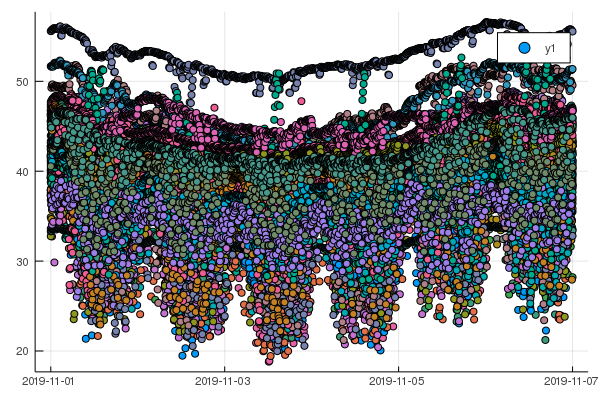

In [91]:
t = JuliaDB.filter(
    r -> r.datetime >= Dates.DateTime("2019-11-01") && r.datetime <= Dates.DateTime("2019-11-07"),
    data,
)
t = JuliaDB.sort(t, :node_id)

In [96]:
for g in JuliaDB.rows(JuliaDB.groupby(JuliaDB.table, t, :node_id))
    @df g.table plot(:datetime, :meter_primreturntemp)
end

Complex plot,